<a href="https://colab.research.google.com/github/Albertogalred/Data-Science/blob/TFM/NeumoX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ENVIRONMENT SETUP AND CONFIGURATION**

Keras is a model-level library, providing high-level building blocks for developing deep learning models

In [1]:
!pip install keras

1.-PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks.

2.- Google authentication - Click the link after executing the following commands

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

3.- Get the identifier of the files in the MyDrive folder

In [3]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: val.zip, id: 1c9VfEbc_WezjvwstMy6D1Zpl5xcmcYH4
title: .ipynb_checkpoints, id: 1-2mIbiWIas_CexviyUBV0SDUNQNRSRT8
title: train.zip, id: 1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp
title: NeumoX, id: 1bSyXkNyzwrxPajbY-WNTiCCs4ycwcYnW
title: test.zip, id: 1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx
title: Colab Notebooks, id: 1Iz8nrdf6kHl5Jimc2xL9zcws8JEA1MUZ


The images have been obtained from:

https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433

In [4]:
file_id = '1udaEEc4Zd9Rc-JJE7dyl5KWzpWl_F8Sp'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("train.zip")

file_id = '1auHH5qiRaHh4T0bNR_MVe1kOkczY4nmx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("test.zip")

We unzip the information and create the folders for the training, test and validation data

In [5]:
!mkdir NeumoX
!cd NeumoX && unzip -q ../train.zip
!cd NeumoX && unzip -q ../test.zip

In [6]:
!pwd

/content


**MODULES IMPORT**

In [7]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dropout,MaxPool2D,Softmax,Input,ELU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add
from keras.metrics import categorical_accuracy
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm  
import cv2   
import scipy
import skimage
from skimage.transform import resize
from matplotlib import pyplot
import matplotlib.pyplot as plt
import h5py
import os, shutil
import glob
import time
import random


**IMAGE PROCESSING AND DISPLAY**

List containing the names of the entries in the directory given by path

In [8]:
Train_normal = os.listdir('../content/NeumoX/train/NORMAL/')
Train_neumonia = os.listdir('../content/NeumoX/train/PNEUMONIA/')

Sample of 10 healthy lungs

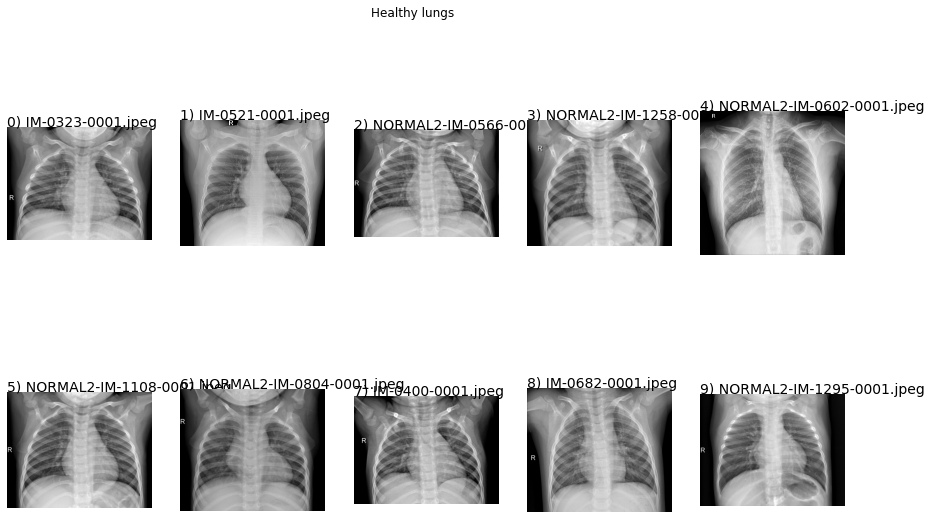

In [9]:
Pnormal = random.sample(Train_normal,10)
f,ax = plt.subplots(2,5,figsize=(15,9))
for i in range(0,10):
    filename=Pnormal[i]
    im = cv2.imread('../content/NeumoX/train/NORMAL/' + Pnormal[i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Healthy lungs')
plt.show()

Sample of 10 diseased lungs

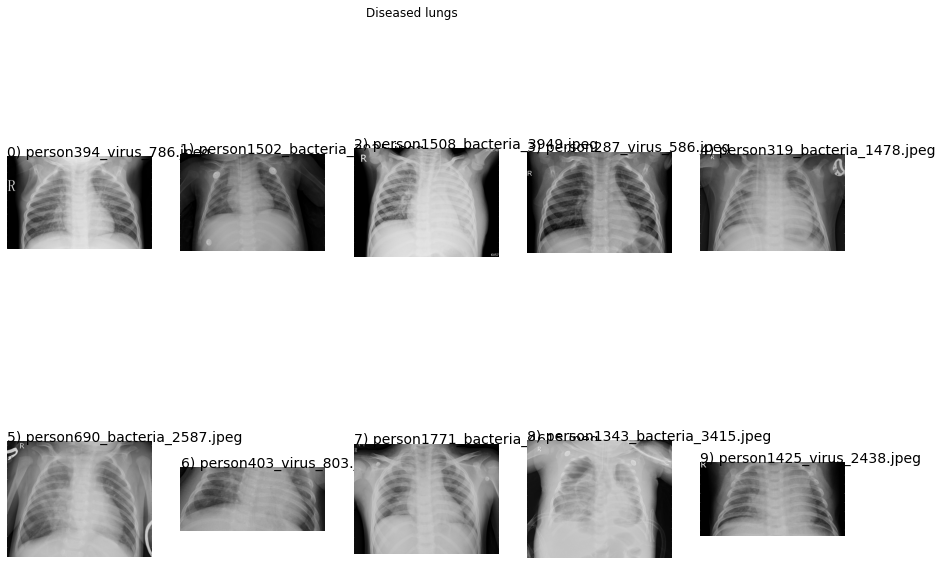

In [10]:
Pneumonia = random.sample(Train_neumonia,10)
f,ax = plt.subplots(2,5,figsize=(15,10))

for i in range(0,10):
    filename=Pneumonia[i]
    im = cv2.imread('../content/NeumoX/train/PNEUMONIA/'+Pneumonia[i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Diseased lungs')
plt.show()

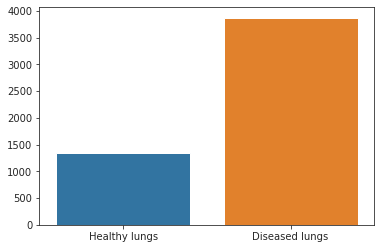

In [11]:
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
#sns.set_style('darkgrid')
sns.set_style("ticks")
sns.barplot(x=['Healthy lungs','Diseased lungs'],y=[len(Train_normal),len(Train_neumonia)]);

**IMAGE SIZING**

In [12]:
#np.random.seed(1)
#set_seed(1)

Import Backend utilities

Returns the default image data format convention ('channels_first' or 'channels_last').

Channels first means that in a specific tensor (consider a photo), you would have (Number_Of_Channels, Height , Width).

Channels last means channels are on the last position in a tensor(n-dimensional array).

We have only one channel (greyscale images)

In [13]:

from tensorflow.keras import backend as K

img_width, img_height = 64, 64

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(64, 64, 1)

**LIFE-CYCLE FOR NEURAL NETWORK MODEL IN KERAS**

1.   Define Network
2.   Compile Network
3.   Fit Network
4.   Evaluate Network
5.   Make Predictions

**NEURAL NETWORK MODEL**

Sequential model

In [14]:
## Construction of the Keras Sequential model begins.
model=tf.keras.models.Sequential()

#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
#First convolutional layer with elu-activation
#2D convolution layer (e.g. spatial convolution over images)
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

# For the Conv2D function the specifications and recommendations of the web page have been followed:
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

#Fully connected layers are defined using the Dense class. We can specify the number of neurons or nodes in the layer as the first argument
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
#As the training is not multiclass (a lung is healthy or not), we will use Softmax for the final layer.
model.add(tf.keras.layers.Activation('softmax'))

# Different neural network models have been tested, being the one indicated in this code the one that has given the best results
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

**IMAGE DATA PREPROCESSING**

In [15]:
TRAIN_DIR = "../content/NeumoX/train/"
TEST_DIR =  "../content/NeumoX/test/"

In [16]:
#Generate batches of tensor image data with real-time data augmentation
train_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
test_datagen=image.ImageDataGenerator(rescale=1./255.0)

In [17]:
%matplotlib inline
gen = image.ImageDataGenerator()
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_batches = train_datagen.flow_from_directory("../content/NeumoX/train/",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16, class_mode='binary')
test_batches = test_datagen.flow_from_directory("../content/NeumoX/test/", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**COMPILING THE MODEL**

In [18]:
#We will define the optimizer as the efficient stochastic gradient descent algorithm “adam“
#This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems
#Finally, because it is a classification problem, we will collect and report the classification sparse_categorical_accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

**TRAIN THE MODEL**

In [19]:
#We have defined our model and compiled it ready for efficient computation
#Trains the model for a given number of epochs
history=model.fit(train_batches,validation_data=test_batches,epochs=100, steps_per_epoch=80, validation_steps=20)

Epoch 1/100
80/80 [==============================] - 48s 233ms/step - loss: 2.0413 - sparse_categorical_accuracy: 0.5960 - val_loss: 3.2685 - val_sparse_categorical_accuracy: 0.2688
Epoch 2/100
80/80 [==============================] - 18s 229ms/step - loss: 0.7170 - sparse_categorical_accuracy: 0.7347 - val_loss: 6.4798 - val_sparse_categorical_accuracy: 0.2688
Epoch 3/100
80/80 [==============================] - 18s 229ms/step - loss: 0.5140 - sparse_categorical_accuracy: 0.7814 - val_loss: 3.3412 - val_sparse_categorical_accuracy: 0.2719
Epoch 4/100
80/80 [==============================] - 18s 227ms/step - loss: 0.4677 - sparse_categorical_accuracy: 0.8091 - val_loss: 6.1309 - val_sparse_categorical_accuracy: 0.2781
Epoch 5/100
80/80 [==============================] - 18s 224ms/step - loss: 0.4057 - sparse_categorical_accuracy: 0.8366 - val_loss: 1.3020 - val_sparse_categorical_accuracy: 0.7063
Epoch 6/100
80/80 [==============================] - 18s 227ms/step - loss: 0.3674 - spars

**MODEL EVALUATION**

Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data.

The model evaluates the loss across all of the test patterns, as well as any other metrics specified when the model was compiled, like classification accuracy. A list of evaluation metrics is returned.

In [20]:
score = model.evaluate(test_batches, verbose=0)
print('Test sparse_categorical_accuracy:', score[1])
print('Test loss:', score[0])

Test sparse_categorical_accuracy: 0.9134615659713745
Test loss: 0.22723300755023956


In [21]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


**PREDICT WITH TEST DATA**

In [22]:
tam = len(test_batches)
prediccion_1 = model.predict(test_batches, verbose=True)
prediccion_2 = pd.DataFrame(prediccion_1)
prediccion_2['item']=prediccion_2.reset_index().index
prediccion_2["filename"] = test_batches.filenames
prediccion_2["label"] = (prediccion_2["filename"].str.contains("PNEUMONIA")).apply(int)
prediccion_2['prediccion_2'] = (prediccion_2[1]>0.5).apply(int) #In the test dataset, I indicate that more than a 0.5 probability of being 1 is a 1
print(prediccion_2)
print(prediccion_2.columns)
#batch_size=16 / Found 624 images belonging to 2 classes --> 39

39/39 [==============================] - 6s 138ms/step
            0         1  ...  label prediccion_2
0    0.978545  0.021455  ...      0            0
1    0.982790  0.017210  ...      0            0
2    0.957241  0.042759  ...      0            0
3    0.907742  0.092258  ...      0            0
4    0.969815  0.030185  ...      0            0
..        ...       ...  ...    ...          ...
619  0.000006  0.999994  ...      1            1
620  0.000010  0.999990  ...      1            1
621  0.015522  0.984478  ...      1            1
622  0.016470  0.983530  ...      1            1
623  0.201760  0.798240  ...      1            1

[624 rows x 6 columns]
Index([0, 1, 'item', 'filename', 'label', 'prediccion_2'], dtype='object')


Accuracy = items classified correctly\all items classified

In [23]:
print("Accuracy score ", accuracy_score(prediccion_2["label"], prediccion_2["prediccion_2"]))

Accuracy score  0.9134615384615384


**GRAPHICS AND METRICS**

In [24]:
def plot_metric(history, metric):
    history_loss = history.history #Loss
    vmetricas = history_loss[metric]
    print(vmetricas)
    if 'val_' + metric in history_loss.keys():  
        val_vmetricas = history_loss['val_' + metric]
        
    epochs = range(1, len(vmetricas) + 1)

    if 'val_' + metric in history_loss.keys():  
        plt.plot(epochs, val_vmetricas, label='Test')
    plt.semilogy(epochs, vmetricas, label='Training')

    if 'val_' + metric in history_loss.keys():  
        plt.title('Training and test %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()


[1.4262367486953735, 0.6610931754112244, 0.5288253426551819, 0.43380603194236755, 0.41384705901145935, 0.37687182426452637, 0.41028714179992676, 0.36511537432670593, 0.31347134709358215, 0.3624853193759918, 0.29337793588638306, 0.28057587146759033, 0.2444687783718109, 0.26600879430770874, 0.2724502682685852, 0.23003241419792175, 0.2629803717136383, 0.23375269770622253, 0.24529817700386047, 0.23910324275493622, 0.21867744624614716, 0.1924421787261963, 0.20294781029224396, 0.19246160984039307, 0.22230012714862823, 0.1849515736103058, 0.21682682633399963, 0.19055327773094177, 0.1908959448337555, 0.16356408596038818, 0.16488908231258392, 0.19352035224437714, 0.19357618689537048, 0.20564427971839905, 0.17188270390033722, 0.19334638118743896, 0.22191902995109558, 0.18884694576263428, 0.1872447282075882, 0.1497631072998047, 0.19438031315803528, 0.19545255601406097, 0.1901799440383911, 0.19668903946876526, 0.19443939626216888, 0.15940606594085693, 0.17155572772026062, 0.1713193655014038, 0.191

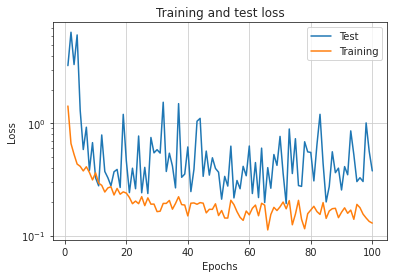

In [25]:
    plot_metric(history,'loss')

[0.635937511920929, 0.758593738079071, 0.7671874761581421, 0.8179687261581421, 0.828125, 0.862500011920929, 0.82421875, 0.84765625, 0.874218761920929, 0.8539062738418579, 0.8812500238418579, 0.882031261920929, 0.909375011920929, 0.90625, 0.8968750238418579, 0.910937488079071, 0.903124988079071, 0.917187511920929, 0.9078124761581421, 0.9125000238418579, 0.9281250238418579, 0.936718761920929, 0.921093761920929, 0.9242187738418579, 0.922656238079071, 0.9390624761581421, 0.930468738079071, 0.925000011920929, 0.9296875, 0.9390624761581421, 0.9453125, 0.930468738079071, 0.9281250238418579, 0.9234374761581421, 0.9375, 0.9234374761581421, 0.921875, 0.922656238079071, 0.936718761920929, 0.953906238079071, 0.9234374761581421, 0.9203125238418579, 0.940625011920929, 0.9398437738418579, 0.930468738079071, 0.932812511920929, 0.936718761920929, 0.9468749761581421, 0.9296875, 0.94921875, 0.9429687261581421, 0.9468749761581421, 0.9437500238418579, 0.9296875, 0.942187488079071, 0.9453125, 0.94921875, 0.

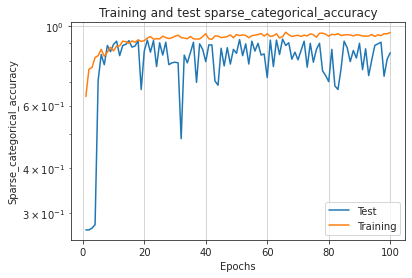

In [26]:
plot_metric(history,'sparse_categorical_accuracy')

The value of sparse_categorical_accuracy indicates the part of the correct conjectures: we can see that as we run epochs it increases its value until it reaches the maximum. On the other hand, the value of val_sparse_categorical_accuracy, which is calculated with the test data that has not been used in the training, is lower reaching a threshold that cannot be exceeded. This is exactly what tells us that the **Overfitting** effect is taking place from a number of epochs.

**100 first predictions**

In [27]:
prediccion_2[:30]

,0,1,item,filename,label,prediccion_2
0,0.978545,0.021455,0,NORMAL/IM-0001-0001.jpeg,0,0
1,0.982790,0.017210,1,NORMAL/IM-0003-0001.jpeg,0,0
2,0.957241,0.042759,2,NORMAL/IM-0005-0001.jpeg,0,0
3,0.907742,0.092258,3,NORMAL/IM-0006-0001.jpeg,0,0
4,0.969815,0.030185,4,NORMAL/IM-0007-0001.jpeg,0,0
5,0.972080,0.027920,5,NORMAL/IM-0009-0001.jpeg,0,0
6,0.970312,0.029688,6,NORMAL/IM-0010-0001.jpeg,0,0
7,0.962533,0.037467,7,NORMAL/IM-0011-0001-0001.jpeg,0,0
8,0.940595,0.059405,8,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,0.979113,0.020887,9,NORMAL/IM-0011-0001.jpeg,0,0


Example wrong prediction - Healthy lung that the model has predicted to be a diseased lung

Indicates a wrong item from the table above
16


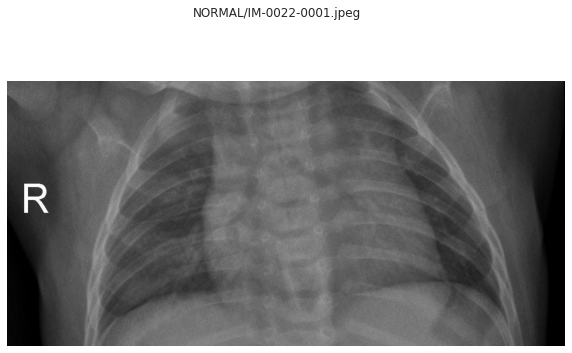

In [28]:
print("Indicates a wrong item from the table above")
Erronea = input()
Erronea = int(Erronea)
prediccion_2["filename"][Erronea]
f,ax = plt.subplots(1,1,figsize=(10,6))
im = cv2.imread('../content/NeumoX/test/'+prediccion_2["filename"][Erronea])
ax.imshow(im)
ax.axis('off')
f.suptitle(prediccion_2["filename"][Erronea])
plt.show()

**CONFUSION MATRIX**

It is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class

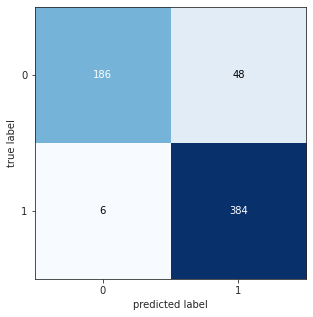

In [29]:
CMatrix = confusion_matrix(prediccion_2["label"], prediccion_2["prediccion_2"])
fig, ax = plot_confusion_matrix(conf_mat=CMatrix ,  figsize=(5, 5))
plt.show()

**PRECISION AND RECALL**

1.   The precise definition of **recall** is the number of true positives divided by the number of true positives plus the number of false negatives
2.   **Precision** is defined as the number of true positives divided by the number of true positives plus the number of false positives
3.   The **F1 score** is the harmonic mean of precision and recall taking both metrics into account. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).




In [30]:
# Calculate Precision and Recall
tn, fp, fn, vp = CMatrix.ravel()
print(tn, fp, fn, vp,CMatrix)
precision = vp/(vp+fp)
recall = vp/(vp+fn)
F1_score = 2*(precision*recall)/(precision+recall)

186 48 6 384 [[186  48]
 [  6 384]]


In [31]:
print("Precision of the model is {:.2f}".format(precision))
print("Recall of the model is {:.2f}".format(recall))
print("F1_score of the model is {:.2f}".format(F1_score))

Precision of the model is 0.89
Recall of the model is 0.98
F1_score of the model is 0.93


**WRONG PREDICTIONS**

In [32]:
wrong=np.where(prediccion_2['prediccion_2']!=prediccion_2['label'])[0]

In [33]:
print(" Number of wrong prediction:", len(wrong))

 Number of wrong prediction: 54


In [34]:
wrong

array([ 16,  52,  66,  80,  87,  89,  93,  98, 104, 108, 109, 113, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145,
       146, 147, 158, 166, 167, 171, 193, 220, 226, 288, 317, 382, 388,
       390, 599])

**CLASSIFICATION REPORT**

Build a text report showing the main classification metrics

In [35]:
Etiq = ['Normal lung', 'Diseased lung']
print(classification_report(prediccion_2["label"], prediccion_2["prediccion_2"], target_names=Etiq))
#Support: number of observations for each class.
#Macro average: the arithmetic average of a metric between the two classes.
#  Example: Macro average(precision) = (p0 + p1)/2 = (0.93 + 0.89)/2 = 0.91 = 91%
#Weighted average: the weighted average is calculated by dividing sum(metric of interest x weight) by sum(weights)
#  Weighted average (precision)= (p0 x s0 + p1 x s1)/(s0 + s1) = (0.93 x 234) + (0.89 x 390)/(234 + 390) = 0.90 = 90%

               precision    recall  f1-score   support

  Normal lung       0.97      0.79      0.87       234
Diseased lung       0.89      0.98      0.93       390

     accuracy                           0.91       624
    macro avg       0.93      0.89      0.90       624
 weighted avg       0.92      0.91      0.91       624



**AREA BAJO LA CURVA ROC (AUC)**

In [ ]:
# calculate AUC
auc = roc_auc_score(pre["label"], pre["pre"])

In [ ]:
print('AUC: %.3f' % auc)

AUC: 0.899


In [ ]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(pre["label"], pre["pre"])

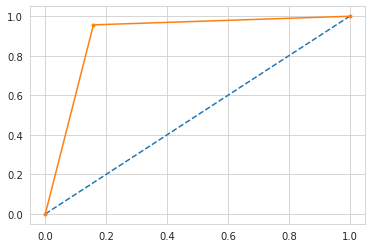

In [ ]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

**RECALL ROC**

In [ ]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(pre["label"], pre["pre"])

f1=0.932 auc=0.899 ap=0.897


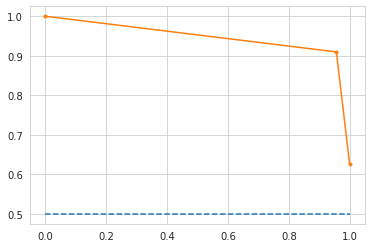

In [ ]:
# calculate F1 score
#
f1 = f1_score( pre["label"], pre["pre"])
# calculate average precision score
ap = average_precision_score(pre["label"], pre["pre"])
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()